In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pandas as pd
import xarray as xr
from odc.geo.xr import xr_reproject
from scipy.stats import kendalltau

from ocr import catalog

warnings.filterwarnings('ignore')

In [2]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
ca = states[states['STUSPS'].isin(['CA'])]
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)
ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]

<Axes: >

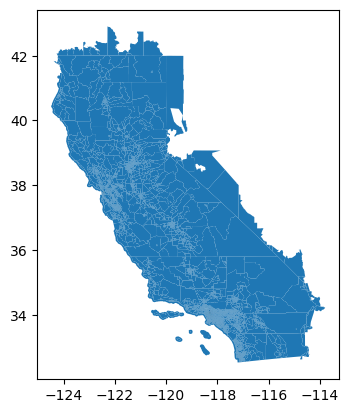

In [41]:
ca_census_tracts.plot()

In [4]:
rebuild_ca_buildings = False
version = 'v0.5.0'
if rebuild_ca_buildings:
    building_file = gpd.read_parquet(
        f's3://carbonplan-ocr/output/fire-risk/vector/production/{version}/geoparquet/buildings.parquet'
    )
    ca = ca.to_crs(building_file.crs)
    # find all rows
    ca_buildings = building_file.loc[building_file.geometry.intersects(ca.unary_union)]
    ca_buildings.to_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )
else:
    ca_buildings = gpd.read_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )

In [4]:
# load in cal fire hazard layer

In [12]:
fpath = 's3://carbonplan-ocr/input/fire-risk/tensor/calfire-fhsz/calfire-risk-raster.tif'
ds = xr.open_dataset(fpath, engine='rasterio')
ds = ds.odc.assign_crs('epsg:3310')
ds_reprojected = xr_reproject(ds, how='EPSG:4326')

In [7]:
# get building coords
coords = [(geom.x, geom.y) for geom in ca_buildings.geometry.centroid]
coords = np.array(coords)

In [6]:
# extract hazard for buildings
building_hazard = ds_reprojected.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

In [7]:
# cast all nulls to zeros. areas with zero are considered not at risk in the cal fire approach
# and by casting them to zero we make them have a lower value than the non-zero values which
# prepares the data for a ranked test like kendall-tau
# TODO: this still retains a few hundred -3 values
building_hazard = xr.where(building_hazard.band_data.isnull(), 0, building_hazard.band_data)

In [11]:
ca_buildings['cal-fire-hazard-zone'] = building_hazard.values[0]

In [42]:
ca_buildings_in_census_tracts = gpd.sjoin(ca_buildings, ca_census_tracts[['GEOID', 'geometry']])

In [43]:
ca_buildings_in_census_tracts.to_parquet(
    f's3://carbonplan-risks/shapefiles/buildings_tracts_california_{version}.parquet'
)

In [44]:
def apply_kendall_tau(x, y, variant):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant=variant)
    return pd.Series({f'tau_{variant}': tau, f'p_value_{variant}': p_value})

In [45]:
tract_tau = ca_buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_kendall_tau(g['wind_risk_2011'], g['cal-fire-hazard-zone'], 'b')
)
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']].merge(tract_tau, on='GEOID')
new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_kendall_tau(g['wind_risk_2011'], g['cal-fire-hazard-zone'], 'c')
)
tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
tract_performance_stats.to_parquet(
    f's3://carbonplan-risks/shapefiles/california_tract_stats_{version}.parquet'
)

In [61]:
variable_name_dict = {
    'tau_b': "Kendall's Tau (b-variant) of RPS",
    'tau_c': "Kendall's Tau (c-variant) of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {
    'tau_b': [-1, 1],
    'tau_c': [-1, 1],
    'bias': [-0.1, 0.1],
    'normalized_bias': [-1, 1],
    'corr': [-1, 1],
}

cmaps = {
    'tau_b': 'PRGn',
    'tau_c': 'PRGn',
    'bias': 'RdBu_r',
    'normalized_bias': 'RdBu_r',
    'corr': 'PRGn',
}

(array([  0.,   0.,   2.,   8.,   5.,  20.,  49.,  81., 151., 392., 396.,
        390., 316., 253., 210., 169., 125.,  38.,  14.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

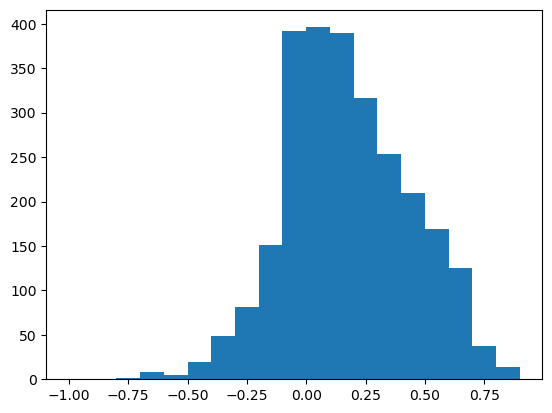

In [98]:
plt.hist(tract_performance_stats['tau_b'].values, bins=np.arange(-1, 1, 0.1))

(array([  2.,   3.,   3.,   4.,   7.,  17.,  31.,  65., 115., 461., 822.,
        295., 223., 189., 166., 102.,  73.,  35.,   7.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

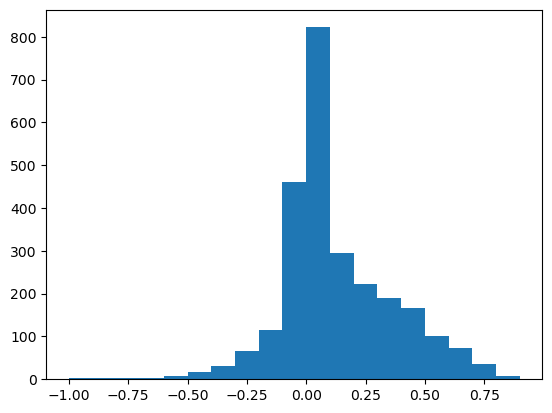

In [99]:
plt.hist(tract_performance_stats['tau_c'].values, bins=np.arange(-1, 1, 0.1))

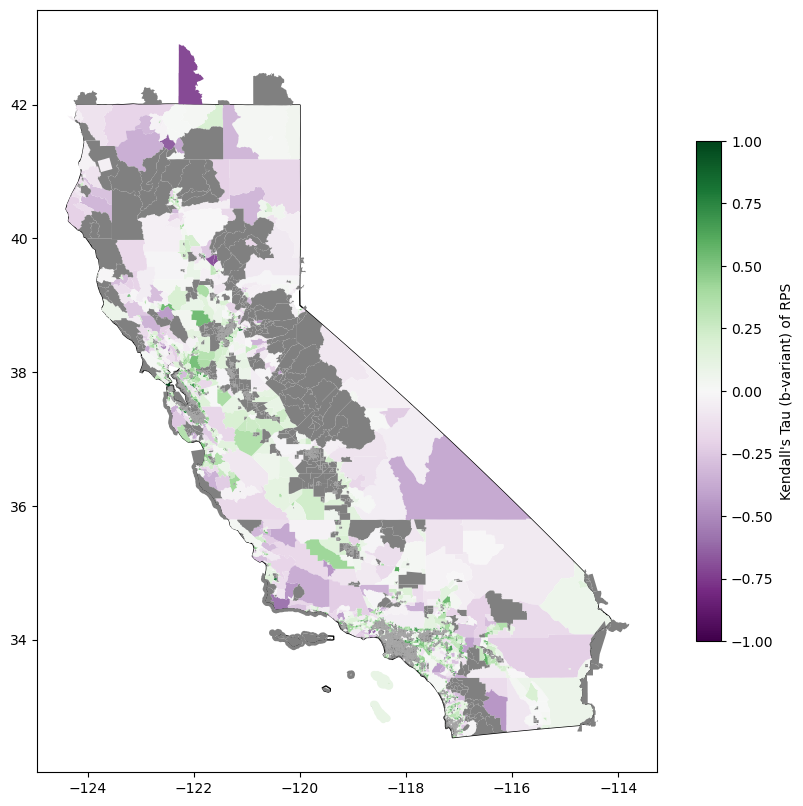

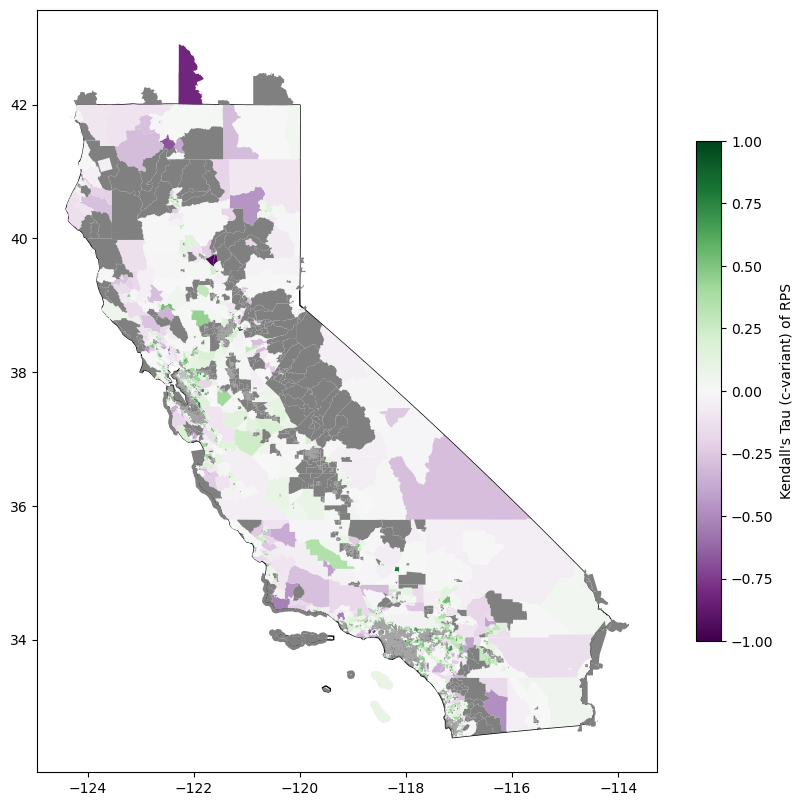

In [95]:
for variable in ['tau_b', 'tau_c']:
    fig, axarr = plt.subplots(figsize=(10, 10))
    ca.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )
    tract_performance_stats[tract_performance_stats['tau_b'].isnull()].plot(ax=axarr, color='grey')

In [5]:
scott2024 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()

In [8]:
scott2024_buildlings = scott2024.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

In [11]:
ca_buildings['scott2024-RPS'] = scott2024_buildlings.RPS.values[0]

In [92]:
import geopandas as gpd
from shapely.geometry import Point

# Example: building_hazard is your xarray dataset with dims 'building'
lons = building_hazard.longitude.values
lats = building_hazard.latitude.values

# Create Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(lons, lats)]

# Create GeoDataFrame, optionally add other data columns
gdf = gpd.GeoDataFrame({'hazard': building_hazard.values[0]}, geometry=geometry, crs='EPSG:4326')